In [2]:
import matplotlib
import pathlib

import mne
print(mne.__version__)

from scipy.io import loadmat, savemat
from fracModel import fracOrdUU
import os
import numpy as np

0.23.0


In [2]:
matplotlib.use('Qt5Agg')

In [3]:
#Locations - Sahil
location_al = "D:\Documents\CS637 project\Original Dataset\data_set_IVa_al_mat\\100Hz\data_set_IVa_al.mat"

In [4]:
import scipy.io
mat = scipy.io.loadmat(location_al)

In [7]:
def get_A(X):
    
    meanX = np.mean(X, axis=1)
    X = X.T - meanX
    X = X.T
    fModel = fracOrdUU(verbose=1)
    fModel.fit(X)
    
    return fModel._AMat[-1]

In [6]:
sfreq = mat['nfo']['fs'][0][0][0][0]

EEGdata = mat['cnt'].T
EEGdata = 1e-1*EEGdata   #To convert to uV

nchannels, nsamples = EEGdata.shape

ch_names = [s[0] for s in mat['nfo']['clab'][0][0][0]]

event_onsets = mat['mrk'][0][0][0]
event_codes = mat['mrk'][0][0][1]

labels = np.zeros((1, nsamples), int)
labels[0, event_onsets] = event_codes

cl_lab = [s[0] for s in mat['mrk']['className'][0][0][0]]
cl1 = cl_lab[0]
cl2 = cl_lab[1]

xpos = mat['nfo']['xpos'][0][0]
ypos = mat['nfo']['ypos'][0][0]

nclasses = len(cl_lab)
nevents = len(event_onsets.transpose())

In [7]:
trials = {}

win = np.arange(int(0*sfreq), int(3*sfreq))    # Epoch size of each trial (0 to 3 sec)
nsamples = len(win)

In [8]:
for cl, code in zip(cl_lab, np.unique(event_codes)):
    cl_onsets = event_onsets[event_codes == code]
    trials[cl] = np.zeros((nchannels, nsamples, len(cl_onsets)))
    for i, onset in enumerate(cl_onsets):
        trials[cl][:, :, i] = EEGdata[:, win+onset]

In [9]:
right = np.rollaxis(trials[cl1], 2, 0)
foot = np.rollaxis(trials[cl2], 2, 0)

In [10]:
data = np.concatenate([right, foot])

In [11]:
Y = np.concatenate([-np.ones(right.shape[0]), np.ones(foot.shape[0])])    # Labeling right as -1 and foot as 1

In [12]:
# Converting to BIDS using mne
n_channels = 118

info = mne.create_info(
ch_names = ch_names,
ch_types = ['eeg']*nchannels,
sfreq = sfreq)

layout_pos = np.concatenate([xpos, ypos], axis = 1)

layout = mne.channels.generate_2d_layout(
xy = layout_pos,
ch_names = ch_names,
name = "EEG custom layout")

In [13]:
event_id = dict(right = -1, foot = 1)

eventLength = Y.shape[0]
ev = [i*sfreq*3 for i in range(eventLength)]

events = np.column_stack((np.array(ev, dtype = int),
                         np.zeros(eventLength, dtype = int),
                         np.array(Y, dtype = int)))

In [14]:
tmin = 0
epochs = mne.EpochsArray(data, info, events, tmin, event_id)

Not setting metadata
Not setting metadata
224 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


In [18]:
epochs.plot(picks = final_ch_list)

<MNEBrowseFigure size 1920x976 with 4 Axes>

In [16]:
final_ch_list = ["T7", "C5", "C3", "C1", "Cz", "C2", "C4", "C6", "T8"] #Channels which affect motor controls the most

In [23]:
edata = epochs.get_data(picks = final_ch_list)
edata.shape

(224, 9, 300)

In [24]:
edata[0]

array([[-45.9, -45.4, -45.6, ..., -74.8, -80.5, -82.8],
       [  6.8,   9. ,   8.2, ..., -18.1, -24.7, -26.2],
       [-27.7, -24.7, -23.9, ..., -63.5, -67.5, -68.7],
       ...,
       [  9.8,   2.9,   5.1, ..., -26.5, -23. , -21.4],
       [ 13.1,   2.8,   5.7, ...,   0.8,   6.5,   8.1],
       [-34.4, -47.7, -44.6, ..., -18.4, -13.5, -12.7]])

In [25]:
Y.shape

(224,)

In [10]:
edata = np.load("Audata.npz")["X"]
Y = np.load("Audata.npz")["y"]

In [14]:
edata = edata*1e6    #Scale so that EM algo works

In [15]:
edata[0]

array([[ -5.15470755,  -3.14432874,  -2.0314145 , ...,  -1.63594349,
          0.10067975,   2.21421123],
       [ -5.83107443,  -3.52958872,  -1.98812517, ...,  -4.61134055,
         -1.88496661,   0.94532055],
       [ -3.8391348 ,  -2.85403036,  -1.88846885, ...,   2.66928381,
          4.54302294,   6.16168077],
       ...,
       [ -5.38114064,  -4.77771393,  -4.1721551 , ...,   3.12278397,
          4.72275601,   6.30938749],
       [ -4.33310438,  -3.67027474,  -3.17584185, ...,   4.6567451 ,
          6.783997  ,   8.9434462 ],
       [  0.20419303,   2.00336793,   1.75149337, ..., -17.06967326,
        -13.38565904,  -7.69476296]])

In [17]:
print(edata.shape)
print(Y.shape)

(1077, 11, 351)
(1077,)


In [18]:
Adata = np.stack([get_A(x) for x in edata])

beginning mse = 1.980895
iter ind = 0, mse = 0.749728
iter ind = 1, mse = 0.748201
iter ind = 2, mse = 0.747348
time taken = 9.424104
beginning mse = 1.973143
iter ind = 0, mse = 1.141843
iter ind = 1, mse = 1.140583
iter ind = 2, mse = 1.140164
time taken = 17.126491
beginning mse = 1.920762
iter ind = 0, mse = 0.558171
iter ind = 1, mse = 0.556661
iter ind = 2, mse = 0.555943
time taken = 16.058594
beginning mse = 1.480192
iter ind = 0, mse = 0.726281
iter ind = 1, mse = 0.725003
iter ind = 2, mse = 0.724810
time taken = 8.772086
beginning mse = 1.776713
iter ind = 0, mse = 1.076783
iter ind = 1, mse = 1.075988
iter ind = 2, mse = 1.075853
time taken = 12.078006
beginning mse = 1.885438
iter ind = 0, mse = 0.904714
iter ind = 1, mse = 0.903634
iter ind = 2, mse = 0.903324
time taken = 12.113069
beginning mse = 1.526339
iter ind = 0, mse = 0.583896
iter ind = 1, mse = 0.583703
iter ind = 2, mse = 0.583579
time taken = 10.834140
beginning mse = 1.761093
iter ind = 0, mse = 0.853661
ite

In [19]:
np.savez('AdataAu.npz', Adata = Adata, Y = Y)

#### Feature extraction

In [20]:
# Loading Data
Adata = np.load("AdataAu.npz")["Adata"]
Y = np.load("AdataAu.npz")["Y"]

In [39]:
Ago = np.stack([Adata[i] for i in range(Adata.shape[0]) if Y[i]==2])
Anogo = np.stack([Adata[i] for i in range(Adata.shape[0]) if Y[i]==4])
Abp = np.stack([Adata[i] for i in range(Adata.shape[0]) if Y[i]==5])

In [81]:
Ygo = np.stack([Y[i] for i in range(Adata.shape[0]) if Y[i]==2])
Ybp = np.stack([Y[i] for i in range(Adata.shape[0]) if Y[i]==5])

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline

In [44]:
AgoAv = np.average(Ago, axis = 0)
AnogoAv = np.average(Anogo, axis = 0)
AbpAv = np.average(Abp, axis = 0)

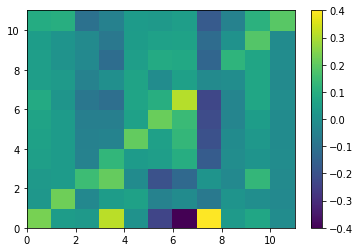

In [53]:
fig = plt.figure()
f = plt.pcolormesh(AgoAv, vmin=-0.4, vmax=0.4)
plt.colorbar(f)

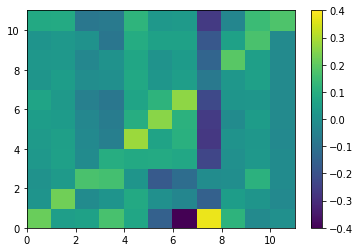

In [55]:
fig = plt.figure()
f = plt.pcolormesh(AbpAv, vmin=-0.4, vmax=0.4)
plt.colorbar(f)

## Applying ML

In [98]:
X = np.stack([np.concatenate([a[:, i] for i in range(11)]) for a in np.concatenate([Ago, Abp])])

In [95]:
Y = np.concatenate([Ygo, Ybp])

In [96]:
Y.shape

(957,)

In [99]:
X.shape

(957, 121)

In [100]:
import pandas as pd
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)

#### Logistic Regression

In [101]:
from sklearn.linear_model import LogisticRegression
Logclassifier = LogisticRegression(random_state = 0)
Logclassifier.fit(X_train, y_train)

D:\Softwares\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [102]:
y_pred_log = Logclassifier.predict(X_test)

In [103]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_log)
print(cm)

[[55 34]
 [68 35]]


In [104]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = Logclassifier, X = X_train, y = y_train, cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

D:\Softwares\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
D:\Softwares\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressio

Accuracy: 52.14 %
Standard Deviation: 7.67 %


D:\Softwares\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


#### Kernal SVM

In [105]:
from sklearn.svm import SVC
SVCclassifier = SVC(kernel = 'rbf', random_state = 0)
SVCclassifier.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False)

In [106]:
y_pred_SVC = SVCclassifier.predict(X_test)

In [107]:
y_pred_SVC

array([2, 2, 2, 2, 5, 2, 5, 2, 2, 5, 2, 2, 5, 5, 5, 5, 5, 2, 2, 2, 5, 5,
       2, 5, 5, 2, 2, 2, 2, 5, 2, 5, 2, 2, 2, 2, 5, 5, 2, 2, 5, 2, 2, 2,
       5, 2, 5, 5, 5, 2, 2, 5, 2, 2, 2, 2, 2, 5, 2, 5, 5, 2, 2, 2, 5, 5,
       2, 5, 5, 2, 2, 2, 2, 5, 2, 5, 2, 5, 5, 2, 5, 5, 5, 2, 2, 2, 2, 2,
       5, 5, 5, 2, 2, 2, 2, 5, 2, 2, 5, 2, 2, 2, 2, 2, 2, 2, 5, 2, 5, 2,
       2, 5, 5, 2, 2, 2, 5, 2, 2, 5, 2, 2, 2, 5, 2, 2, 5, 2, 2, 5, 2, 5,
       2, 5, 2, 5, 5, 5, 2, 2, 2, 2, 5, 2, 2, 5, 2, 5, 2, 5, 2, 5, 2, 2,
       5, 2, 2, 5, 2, 2, 2, 5, 2, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 2, 2,
       5, 5, 2, 5, 2, 5, 5, 2, 2, 5, 2, 2, 2, 2, 2, 5])

In [108]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred_SVC)
print(cm)
accuracy_score(y_test, y_pred_SVC)

[[54 35]
 [66 37]]


0.4739583333333333

#### Random Forest

In [109]:
from sklearn.ensemble import RandomForestClassifier
RFclassifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
RFclassifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [110]:
y_pred_RF = RFclassifier.predict(X_test)

In [111]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred_RF)
print(cm)
accuracy_score(y_test, y_pred_RF)

[[62 27]
 [72 31]]


0.484375

#### KNN

In [112]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.naive_bayes import GaussianNB
# from sklearn.svm import SVC
# from sklearn.datasets import load_digits
# from sklearn.model_selection import learning_curve
# from sklearn.model_selection import ShuffleSplit

In [113]:
from sklearn.neighbors import KNeighborsClassifier
KNNclassifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
KNNclassifier.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [114]:
y_pred_KNN = KNNclassifier.predict(X_test)

In [115]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred_KNN)
print(cm)
accuracy_score(y_test, y_pred_KNN)

[[39 50]
 [63 40]]


0.4114583333333333

#### Naive Bayes

In [116]:
from sklearn.naive_bayes import GaussianNB
NBclassifier = GaussianNB()
NBclassifier.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [117]:
y_pred_NB = NBclassifier.predict(X_test)

In [118]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred_NB)
print(cm)
accuracy_score(y_test, y_pred_NB)

[[75 14]
 [88 15]]


0.46875

In [119]:
from sklearn.metrics import roc_curve, auc

In [120]:
log_fpr, log_tpr, threshold = roc_curve(y_test, y_pred_log)
auc_log = auc(log_fpr, log_tpr)
SVC_fpr, SVC_tpr, threshold = roc_curve(y_test, y_pred_SVC)
auc_SVC = auc(SVC_fpr, SVC_tpr)
RF_fpr, RF_tpr, threshold = roc_curve(y_test, y_pred_RF)
auc_RF = auc(RF_fpr, RF_tpr)
KNN_fpr, KNN_tpr, threshold = roc_curve(y_test, y_pred_KNN)
auc_KNN = auc(KNN_fpr, KNN_tpr)
NB_fpr, NB_tpr, threshold = roc_curve(y_test, y_pred_NB)
auc_NB = auc(NB_fpr, NB_tpr)

plt.figure()
plt.plot(SVC_fpr, SVC_tpr, linestyle = '-', label = "Suport Vector Machine (auc = %0.3f)"%auc_SVC)
plt.plot(log_fpr, log_tpr, linestyle = '-', label = "Logarithimic regression (auc = %0.3f)"%auc_log)
plt.plot(RF_fpr, RF_tpr, linestyle = '-', label = "Random Forest (auc = %0.3f)"%auc_RF)
#plt.plot(KNN_fpr, KNN_tpr, linestyle = '-', label = "K-Nearest Neighbors (auc = %0.3f)"%auc_KNN)
plt.plot(NB_fpr, NB_tpr, linestyle = '-', label = "Naive Bayes (auc = %0.3f)"%auc_NB)

plt.xlabel("False Postive Rate")
plt.ylabel("True Positive Rate")

plt.legend()
plt.show()

ValueError: y_true takes value in {2, 5} and pos_label is not specified: either make y_true take value in {0, 1} or {-1, 1} or pass pos_label explicitly.

In [121]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense

In [122]:
dict = {2: 0,5: 1}

for i in range(len(y_train)):
    y_train[i] = dict[y_train[i]]
    
num_classes = 2
y_train = tf.keras.utils.to_categorical(y_train, num_classes)

In [123]:
for i in range(len(y_test)):
    y_test[i] = dict[y_test[i]]
    
num_classes = 2
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [127]:
ip = tf.keras.Input(shape = 121)
dense1 = tf.keras.layers.Dense(units = 32, activation = "relu")(ip)
dense2 = tf.keras.layers.Dense(units = 32, activation = "relu")(dense1)
dense3 = tf.keras.layers.Dense(units = 16, activation = "relu")(dense2)
dense4 = tf.keras.layers.Dense(units = 8, activation = "relu")(dense3)
dense4 = tf.keras.layers.Dense(units = 2, activation = "sigmoid")(ip)

Model = tf.keras.models.Model(inputs = ip, outputs = dense4)
Model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 121)]             0         
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 244       
Total params: 244
Trainable params: 244
Non-trainable params: 0
_________________________________________________________________


In [128]:
Model.compile(loss = 'binary_crossentropy', metrics = ['acc'], optimizer = 'adam')

In [129]:
history = Model.fit(X_train, y_train, epochs = 200, validation_data = (X_test, y_test))

Epoch 1/200
24/24 [==============================] - 3s 18ms/step - loss: 0.7603 - acc: 0.5072 - val_loss: 0.7575 - val_acc: 0.5156
Epoch 2/200
24/24 [==============================] - 0s 7ms/step - loss: 0.7429 - acc: 0.5229 - val_loss: 0.7496 - val_acc: 0.5052
Epoch 3/200
24/24 [==============================] - 0s 5ms/step - loss: 0.7311 - acc: 0.5268 - val_loss: 0.7455 - val_acc: 0.5104
Epoch 4/200
24/24 [==============================] - 0s 5ms/step - loss: 0.7217 - acc: 0.5229 - val_loss: 0.7444 - val_acc: 0.4948
Epoch 5/200
24/24 [==============================] - 0s 5ms/step - loss: 0.7148 - acc: 0.5281 - val_loss: 0.7428 - val_acc: 0.5000
Epoch 6/200
24/24 [==============================] - 0s 5ms/step - loss: 0.7096 - acc: 0.5294 - val_loss: 0.7423 - val_acc: 0.4896
Epoch 7/200
24/24 [==============================] - 0s 5ms/step - loss: 0.7049 - acc: 0.5268 - val_loss: 0.7432 - val_acc: 0.4896
Epoch 8/200
24/24 [==============================] - 0s 6ms/step - loss: 0.7003 - 

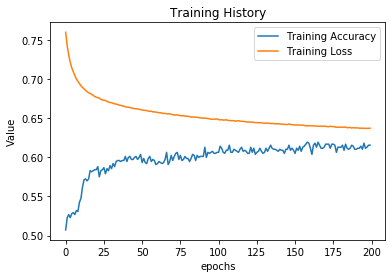

Initial training accuracy with preprocessing is:  0.5071895718574524
Final training accuracy with preprocessing is:  0.615686297416687
Initial training loss with preprocessing is:  0.7603068947792053
Final training loss with preprocessing is:  0.6374294757843018


In [130]:
#Plotting model history
plt.plot(history.history['acc'])
plt.plot(history.history['loss'])
plt.legend(['Training Accuracy', 'Training Loss'])
plt.title('Training History')
plt.ylabel('Value')
plt.xlabel('epochs')
plt.show()
print("Initial training accuracy with preprocessing is: ", history.history['acc'][0])
print("Final training accuracy with preprocessing is: ", history.history['acc'][-1])

print("Initial training loss with preprocessing is: ", history.history['loss'][0])
print("Final training loss with preprocessing is: ", history.history['loss'][-1])

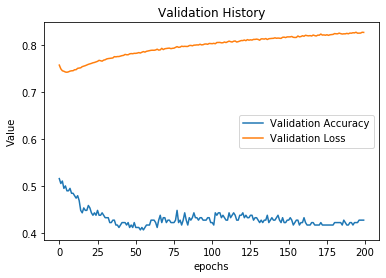

Initial Validation accuracy is:  0.515625
Best Validation accuracy is:  0.515625
Initial Validation loss is:  0.7575197219848633
Best Validation loss is:  0.7423228621482849


In [131]:
#Plotting model history
plt.plot(history.history['val_acc'])
plt.plot(history.history['val_loss'])
plt.legend(['Validation Accuracy', 'Validation Loss'])
plt.title('Validation History')
plt.ylabel('Value')
plt.xlabel('epochs')
plt.show()
print("Initial Validation accuracy is: ", history.history['val_acc'][0])
print("Best Validation accuracy is: ", max(history.history['val_acc']))

print("Initial Validation loss is: ", history.history['val_loss'][0])
print("Best Validation loss is: ", min(history.history['val_loss']))